In [53]:
import pandas as pd
import time
# from skimage import io
# from skimage import filters
import skimage
from skimage import feature
from skimage import morphology
from skimage import measure
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import ndimage as ndi
import numpy as np

start = time.time()

In [2]:
pre_image = skimage.io.imread('../NPP001_Pre.tif')
pre_image = pre_image[0:int(pre_image.shape[0]/4),:]
fin_image = skimage.io.imread('../NPP001_fin.tif')
fin_image = fin_image[0:int(fin_image.shape[0]/4),:]

In [112]:
pre_image.shape

(7471, 21069)

In [3]:
# pre_x_min = 200
# pre_x_max = 3000-2000
# pre_y_min = 1500+1000
# pre_y_max = 4000-1000

# fin_x_min = 200
# fin_x_max = 3000-2000
# fin_y_min = 1500+1000
# fin_y_max = 4000-1000

pre_x_min = 0
pre_x_max = min(pre_image.shape[1], fin_image.shape[1])
pre_y_min = 0
pre_y_max = min(pre_image.shape[0], fin_image.shape[0])

fin_x_min = 0
fin_x_max = min(pre_image.shape[1], fin_image.shape[1])
fin_y_min = 0
fin_y_max = min(pre_image.shape[0], fin_image.shape[0])

bkg_subtract = np.subtract(pre_image[fin_y_min:fin_y_max, fin_x_min:fin_x_max].astype('int16'),
                           fin_image[pre_y_min:pre_y_max, pre_x_min:pre_x_max].astype('int16'))
bkg_subtract[bkg_subtract < 0] = 0
bkg_subtract = bkg_subtract.astype('uint8')

thresh = skimage.filters.threshold_otsu(bkg_subtract)
# print('Binarization threshold is', str(thresh))
binarized = bkg_subtract > thresh

In [4]:
labeled_array, num_features = ndi.label(binarized)
region_info = measure.regionprops(labeled_array)

Found 12574 features.


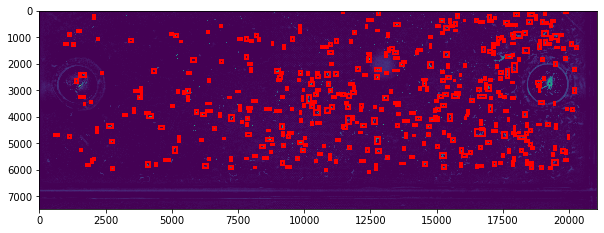

In [91]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(bkg_subtract)

filtered_regions = []
for region in region_info:
    # take regions with reasonable areas
    if (region.area >= 2000 and region.area <=20000):
        # draw rectangle around segmented worms
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        filtered_regions.append(region)
#         if minc>=2500 and minc<3500 and minr>3500 and minr<4500:
#             ax.text(x=minc, y=minr, s=str(region.label), color='white')

# ax.set_ylim(3500, 4500)
# ax.set_xlim(2500, 3500);
# fig.savefig('../filtered_regions.png')

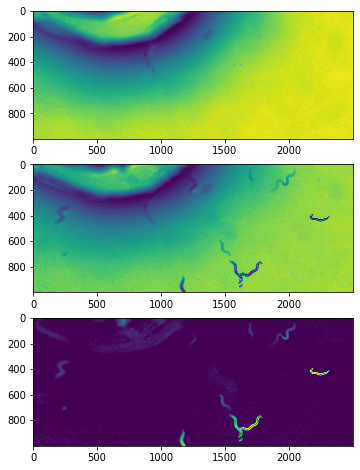

In [119]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 8))

axes[0].imshow(pre_image[3500:4500, 1000:3500])
axes[1].imshow(fin_image[3500:4500, 1000:3500])
axes[2].imshow(bkg_subtract[3500:4500, 1000:3500])

In [105]:
dir(region_info[10220])
region_info[10220].bbox

(4254, 2537, 4437, 2794)

/miniconda2/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  import sys


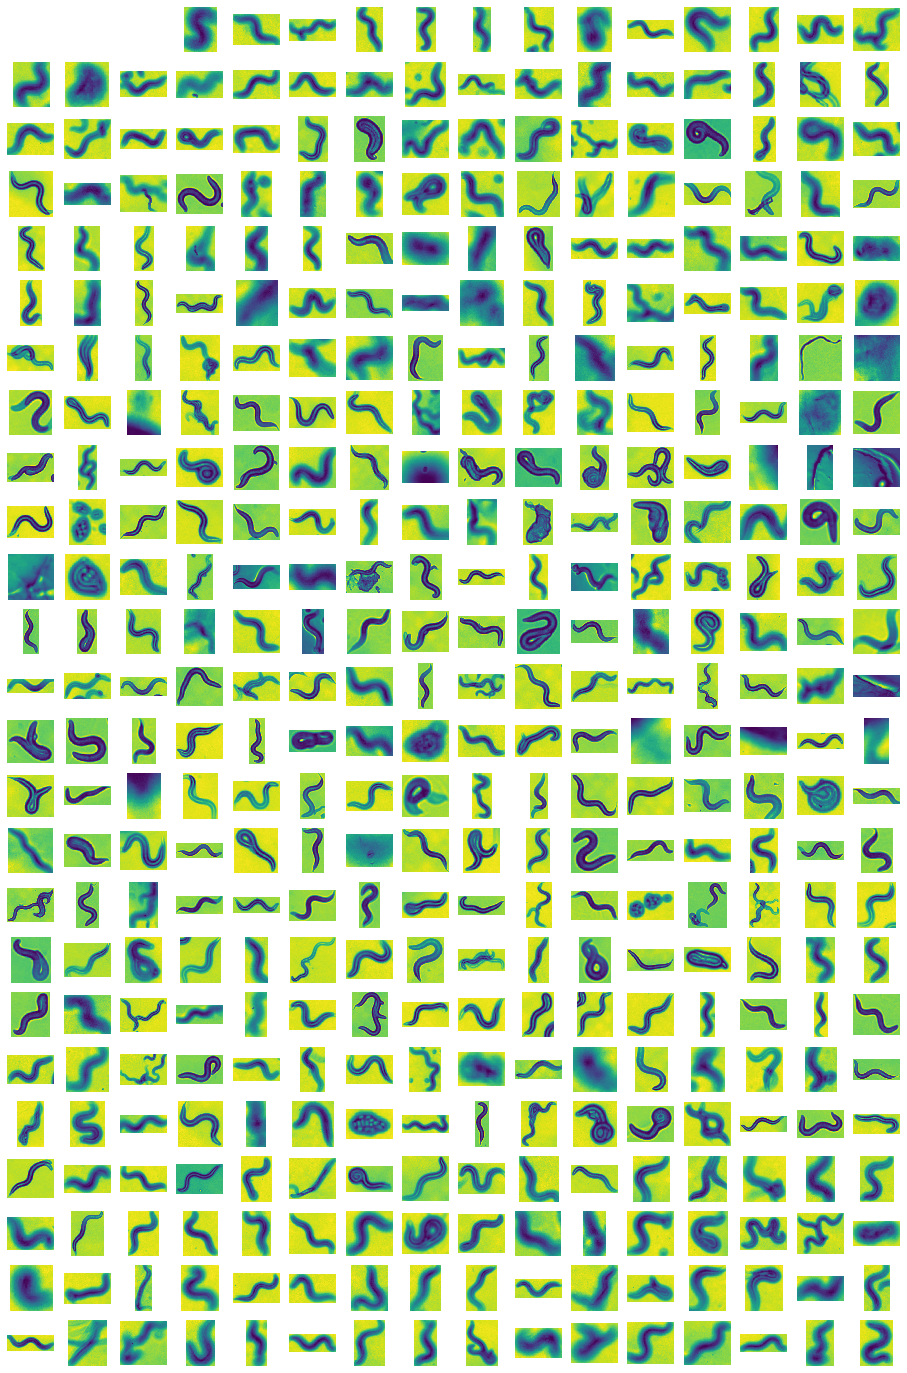

In [111]:
fig, axes = plt.subplots(nrows=25, ncols=16, figsize=(16, 25))
pad = 5
region_num = 0
for row in range(0,25):
    for col in range(0,16):
        bbox = filtered_regions[region_num].bbox
        axes[row, col].imshow(fin_image[bbox[0]-pad:bbox[2]+pad,bbox[1]-pad:bbox[3]+pad])
        axes[row, col].axis('off')
        region_num += 1

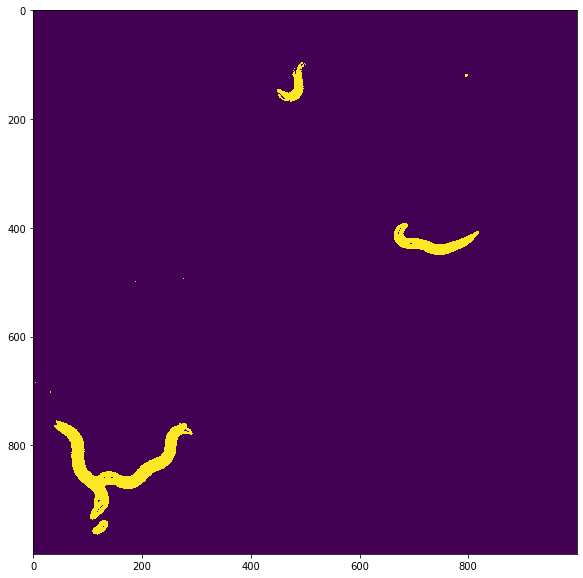

In [114]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
# axes[0].imshow(bkg_subtract[1000:4000, 2000:5000])
axes.imshow(binarized[3500:4500, 2500:3500])
# fig.savefig('../binarized_section_of image.png')

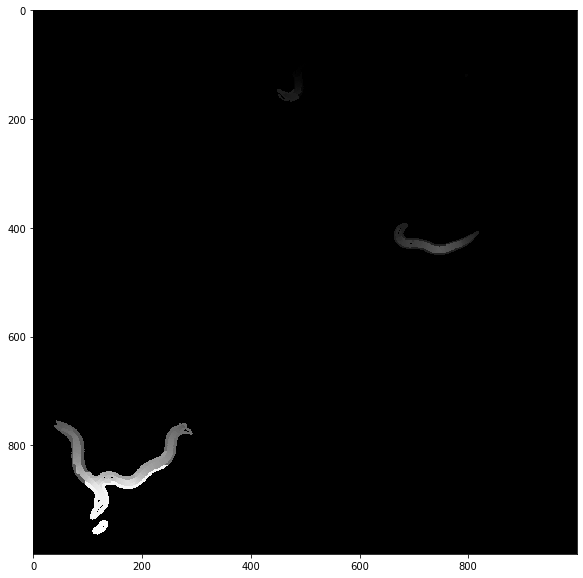

In [71]:
# regions = morphology.watershed(image=bkg_subtract[3500:4500, 2500:3500],# watershed_line=True, 
#                                compactness=.01,#,#markers=labeled_array[3500:4500, 2500:3500],
#                                mask=binarized[3500:4500, 2500:3500])
# # print(str(int(time.time()-start)))
# fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
# # axes[0].imshow(binarized[3500:4500, 2500:3500])
# axes.imshow(regions, cmap=plt.cm.gray)

In [50]:
edges = feature.canny(bkg_subtract[3500:4500, 2500:3500], low_threshold=5, high_threshold=19, sigma=1)
filled_worms = ndi.binary_fill_holes(edges)#, structure=np.ones((3,3)))

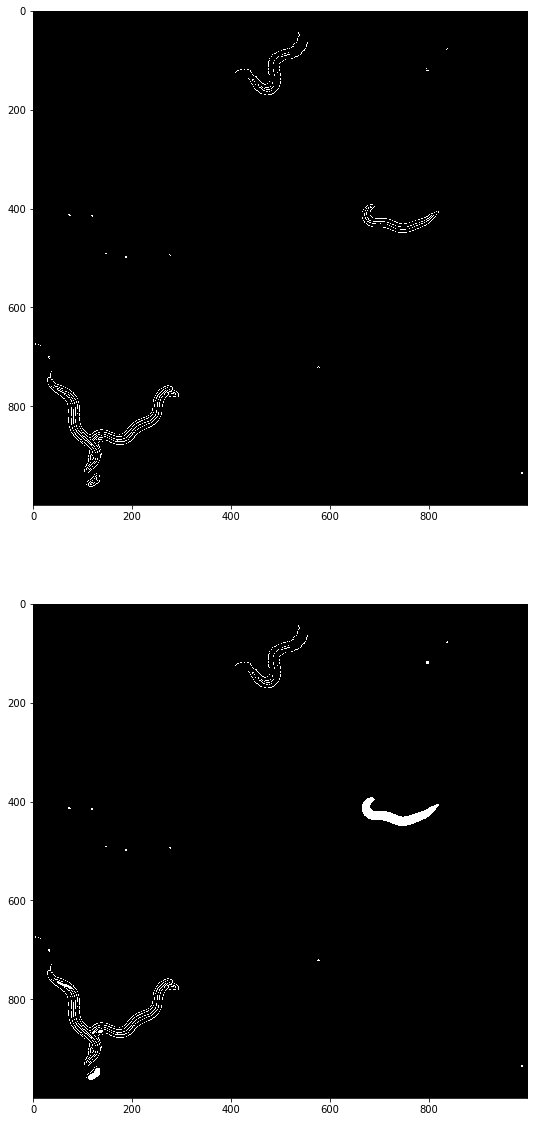

In [51]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10, 20))
axes[0].imshow(edges, cmap=plt.cm.gray)
axes[1].imshow(filled_worms, cmap=plt.cm.gray)

In [9]:
# plt.hist(pre_image.flatten(), bins=16)
# plt.show()

In [10]:
# plt.hist(fin_image.flatten(), bins=16)
# plt.show()

In [11]:
# plt.hist(bkg_subtract.flatten(), bins=16)
# plt.show()

In [12]:
print('Notebook ran in', str(int(time.time()-start)), 'seconds.')

Notebook ran in 41 seconds.
